In [1]:
import numpy as np
import pandas as pd
import os
import skimage.io
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df_train = pd.read_csv("train.csv").reset_index(drop=True)
print("{} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

340 rows and 4 columns


In [3]:
df_test = pd.read_csv("test.csv").reset_index(drop=True)
print("{} rows and {} columns".format(df_test.shape[0], df_test.shape[1]))

86 rows and 2 columns


# Image vizualisation

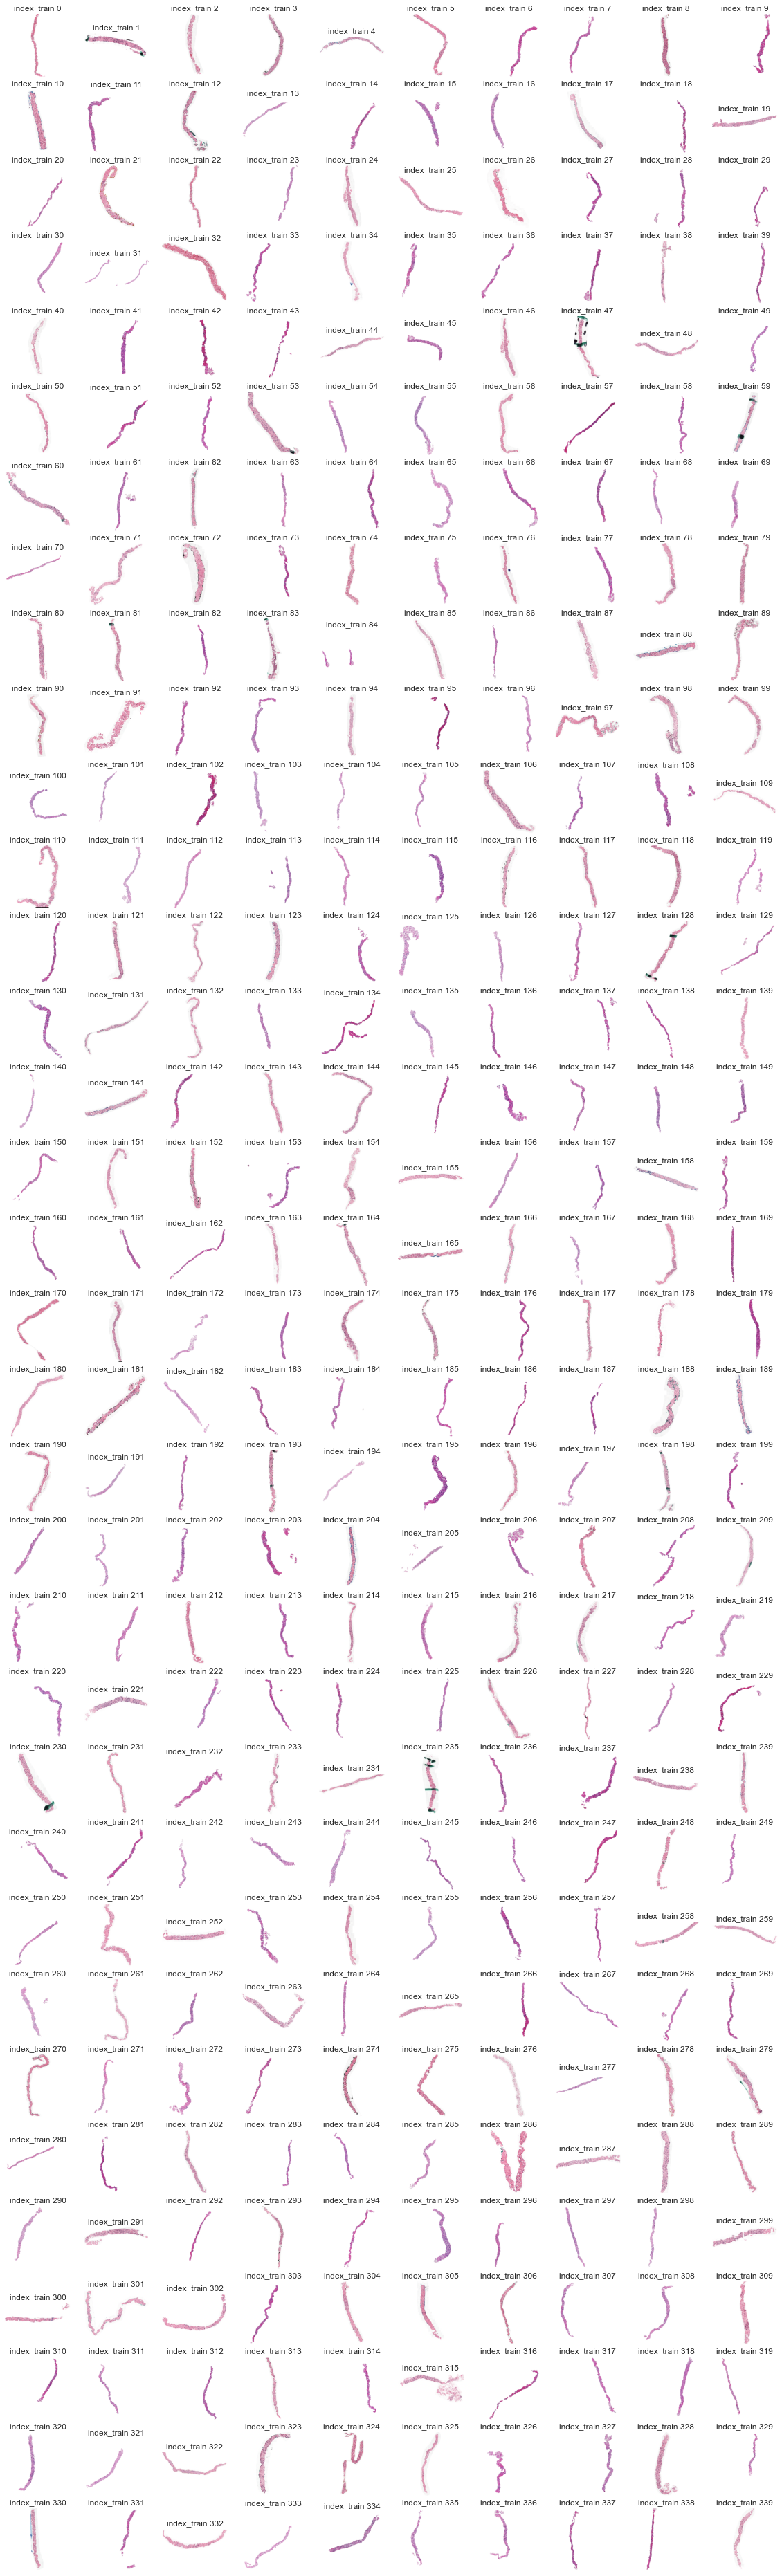

In [4]:
figure, axis = plt.subplots(34, 10, figsize=(20, 68))

for i in range(34):
    for j in range(10):
        row = df_train.iloc[i*10+j]
        img_id = row.image_id    
        tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
        img = cv2.resize(skimage.io.MultiImage(tiff_file)[-1], (0, 0), fx=0.01, fy=0.01)
        axis[i, j].imshow(img)
        axis[i, j].set_title("index_train {}".format(i*10+j))
        axis[i, j].axis("off")

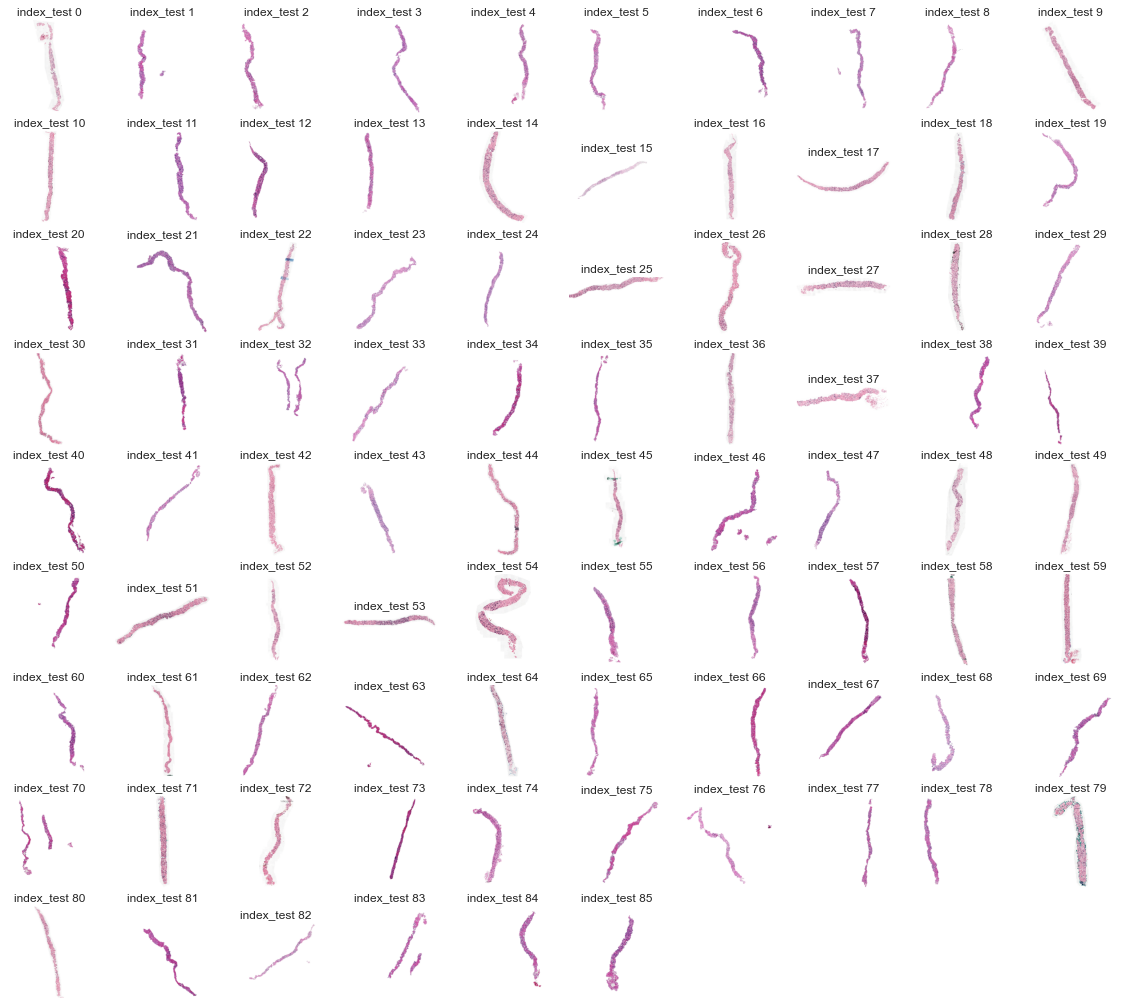

In [5]:
figure, axis = plt.subplots(9, 10, figsize=(20, 18))

for i in range(9):
    for j in range(10):
        if (i==8) and (j in [6, 7, 8, 9, 10]):
             axis[i, j].axis("off")
        else:
            row = df_test.iloc[i*10+j]
            img_id = row.image_id    
            tiff_file = os.path.join("./test/test", f"{img_id}.tiff")
            img = cv2.resize(skimage.io.MultiImage(tiff_file)[-1], (0, 0), fx=0.01, fy=0.01)
            axis[i, j].imshow(img)
            axis[i, j].set_title("index_test {}".format(i*10+j))
            axis[i, j].axis("off")

The images are pink on a white background. We notice that there is sometimes a grayish color around the cutout. It can be interesting to remove the background.

In [6]:
img_id = df_train.iloc[46].image_id
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img1 = skimage.io.MultiImage(tiff_file)[-1]

img_id = df_train.iloc[72].image_id
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img2 = skimage.io.MultiImage(tiff_file)[-1]

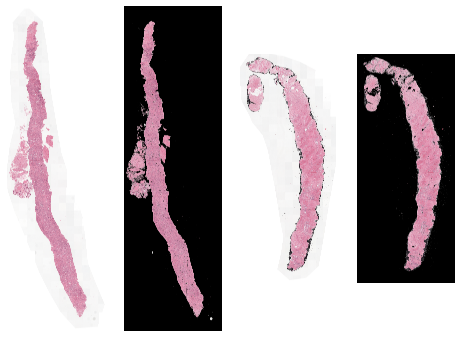

In [7]:
plt.figure(figsize=(8, 8))

plt.subplot(141)
plt.imshow(img1)
plt.axis("off")

img1[img1.mean(axis=-1)>=235] = 0

plt.subplot(142)
plt.imshow(img1)
plt.axis("off")

plt.subplot(143)
plt.imshow(img2)
plt.axis("off")

img2[img2.mean(axis=-1)>=235] = 0

plt.subplot(144)
plt.imshow(img2)
plt.axis("off");

# Image size

In [8]:
def add_shapes(df, path_imgs):
    df["n_rows"] = None
    df["n_cols"] = None
    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        img_id = row.image_id    
        tiff_file = os.path.join(path_imgs, f"{img_id}.tiff")
        img = skimage.io.MultiImage(tiff_file)[-1]
        df.loc[i, "n_rows"] = img.shape[0]
        df.loc[i, "n_cols"] = img.shape[1]

In [9]:
add_shapes(df_train, "./train/train")
add_shapes(df_test, "./test/test")

100%|███████████████████████████████████████████| 86/86 [01:05<00:00,  1.31it/s]


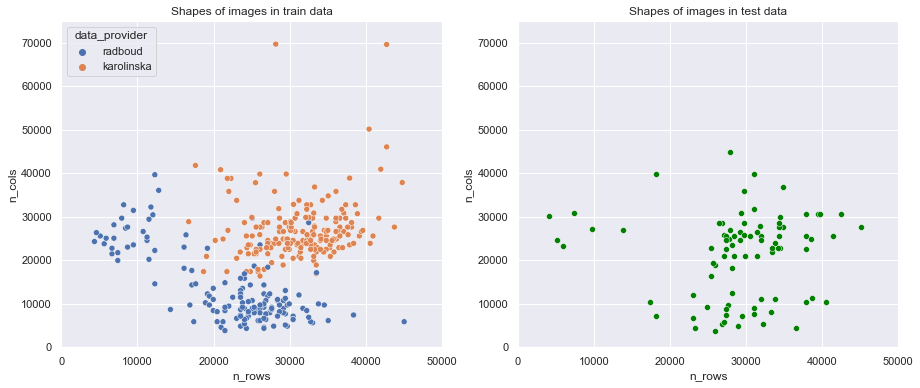

In [10]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.scatterplot(data=df_train, x="n_rows", y="n_cols", hue="data_provider")
plt.title("Shapes of images in train data")
plt.xlim(0, 50000)
plt.ylim(0, 75000)

plt.subplot(122)
sns.scatterplot(data=df_test, x="n_rows", y="n_cols", color="green")
plt.title("Shapes of images in test data")
plt.xlim(0, 50000)
plt.ylim(0, 75000);

The images are not all the same size at all. As the slides are not all the same form, we will use an ingenious technique which consists in breaking down the slide in several tiles, then selecting the tiles with the most tissue.

# Tile selection

In [11]:
def get_tiles(img, tile_size, n_tiles):
    # find by how much we must pad the image so that the image dims are multiples of tile_size
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size
    pad_w = (tile_size - w % tile_size) % tile_size
    # pad the image with constant values (255)
    img = np.pad(img, [[pad_h//2, pad_h - pad_h//2], [pad_w//2, pad_w - pad_w//2], [0, 0]],
                 constant_values=0)
    # reshape the image and swap the order of the dims
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)
    # if the image has less tiles than n_tiles we pad
    if len(img) < n_tiles:
        img = np.pad(img,[[0, n_tiles - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=0)   
    # select the tiles with the most tissue
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[-n_tiles:]
    tiles = img[idxs]
    return tiles

In [12]:
def concat_tiles(tiles, tile_shape):
    image = cv2.hconcat([cv2.vconcat(tiles[ts]) for ts in tile_shape])
    return image

In [13]:
tile_shape = np.array(range(100)).reshape((10, 10))

Let's test this technique on the smallest and the biggest of the slides. <br>
NB: As the images are not all the same size, we can't use a single tile size.

## Smallest slide

In [14]:
img_id = df_train[df_train["n_cols"]==df_train["n_cols"].min()].image_id.values[0]
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img = skimage.io.MultiImage(tiff_file)[-1]

img[img.mean(axis=-1)>=235] = 0
tiles = get_tiles(img, int(np.sqrt((img!=0).sum())/14), 100)
img_tiles = concat_tiles(tiles, tile_shape)

In [15]:
img.shape

(21504, 3840, 3)

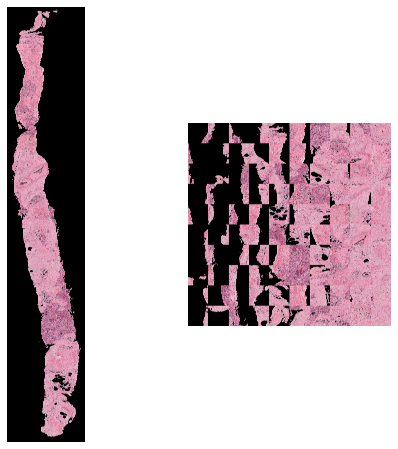

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(img)
plt.axis("off")

plt.subplot(122)
plt.imshow(img_tiles)
plt.axis("off");

In [17]:
print("Proportion of tissue retained in the reduced image: {}%"\
              .format(round(((img_tiles!=0).sum()) / ((img!=0).sum())*100)))

Proportion of tissue retained in the reduced image: 99%


## Biggest slide

In [18]:
img_id = df_train[df_train["n_cols"]==df_train["n_cols"].max()].image_id.values[0]
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img = skimage.io.MultiImage(tiff_file)[-1]

img[img.mean(axis=-1)>=235] = 0
tiles = get_tiles(img, int(np.sqrt((img!=0).sum())/14), 100)
img_tiles = concat_tiles(tiles, tile_shape)

In [19]:
img.shape

(28180, 69719, 3)

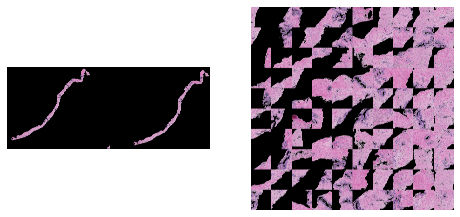

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(img)
plt.axis("off")

plt.subplot(122)
plt.imshow(img_tiles)
plt.axis("off");

In [21]:
print("Proportion of tissue retained in the reduced image: {}%"\
              .format(round(((img_tiles!=0).sum()) / ((img!=0).sum())*100)))

Proportion of tissue retained in the reduced image: 91%


The last step is to resize the tiles so that all processed images have the same size